# Basic CNN Model - Chromogram




#### * Load required libraries

In [9]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
from include import helpers

from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

#### Setup

In [2]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

####  Load data

Data is an NumPy float32 array of shape (8732, 40, 174), 8732 samples with coefficients from Chromogram of 174 frames and 40 MEL bands. Each feature was scaled between -1 and 1 and zero-centered during extraction.

In [3]:
# Pre-processed chromo coefficients
X = np.load("C:/Users/VSBAG/Desktop/DSE_Milan/3rd_sem_subject/Machine Learning/Project/Sound_classification/UrbanSound8K/extracted_features/X-Chromo.npy")
y = np.load("C:/Users/VSBAG/Desktop/DSE_Milan/3rd_sem_subject/Machine Learning/Project/Sound_classification/UrbanSound8K/extracted_features/y-Chromo.npy")

# Metadata
metadata = pd.read_csv("C:/Users/VSBAG/Desktop/DSE_Milan/3rd_sem_subject/Machine Learning/Project/Sound_classification/UrbanSound8K/metadata/UrbanSound8K.csv")
metadata.head(3)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing


###  Data preparation: features + metadata

#### Train / Test split
Note that we are using the same index order for both the Chromogram arrays and the metadata to keep track of the origin of each feature

In [5]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes
X_train,y_train,X_test,y_test,train_split_idx,test_split_idx= split_data(X,y,train=[1,2,3,4,6],test=[5,7,8,9,10])

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 4233 		 Train split: 4499
X test shape: (4233, 40, 174) 	 X train shape: (4499, 40, 174)
y test shape: (4233,) 		 y train shape: (4499,)


# Normalizing the Data

#### One hot encode labels

In [6]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

#### Reshape data

In [7]:
# How data should be structured
num_rows = 40
num_columns = 174 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

In [ ]:
# Class distribution
metadata['class'].value_counts()

Text(0, 0.5, 'Variance (%)')

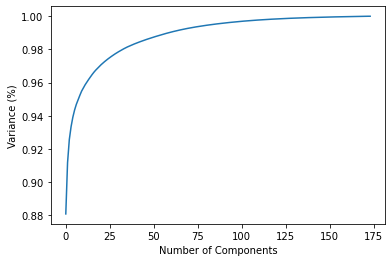

In [10]:
# Check PCA benefits
scaler = StandardScaler()
scaler.fit(X_train[:,0, ::,0])
x_train_scaled = scaler.transform(X_train[:,0, ::,0])

pca = PCA().fit(x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')

##  Basic CNN network

We are using the exact same architecture than the previous notebook.
<br/>

#### Model definition



In [11]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005

model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

#### Setup model optimizer and loss function

Using [ADAM](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) with default parameters to start from somewhere.
Loss function is categorical cross-entropy as we are predicting between 10 classes.


In [12]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 38, 172, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 172, 32)       128       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 38, 172, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 170, 32)       1

#### Training the model



In [13]:
num_epochs = 360
num_batch_size = 128
model_file = 'simple-train-nb3.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=1/12.,
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/360
33/33 [==============================] - 120s 3s/step - loss: 2.1427 - accuracy: 0.2573 - val_loss: 2.4345 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.43451, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\New_Style\models\simple-train-nb3.hdf5
Epoch 2/360
33/33 [==============================] - 112s 3s/step - loss: 1.8837 - accuracy: 0.3712 - val_loss: 2.5607 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 2.43451
Epoch 3/360
33/33 [==============================] - 111s 3s/step - loss: 1.7778 - accuracy: 0.3979 - val_loss: 2.7021 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 2.43451
Epoch 4/360
33/33 [==============================] - 110s 3s/step - loss: 1.6961 - accuracy: 0.4377 - val_loss: 2.8428 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 2.43451
Epoch 5/360
33/33 [==============================] - 109s

33/33 [==============================] - 148s 4s/step - loss: 1.1716 - accuracy: 0.6324 - val_loss: 1.6070 - val_accuracy: 0.4987

Epoch 00031: val_loss did not improve from 1.58947
Epoch 32/360
33/33 [==============================] - 147s 4s/step - loss: 1.1660 - accuracy: 0.6339 - val_loss: 1.6408 - val_accuracy: 0.4960

Epoch 00032: val_loss did not improve from 1.58947
Epoch 33/360
33/33 [==============================] - 148s 5s/step - loss: 1.1529 - accuracy: 0.6438 - val_loss: 1.6415 - val_accuracy: 0.5147

Epoch 00033: val_loss did not improve from 1.58947
Epoch 34/360
33/33 [==============================] - 147s 4s/step - loss: 1.1239 - accuracy: 0.6600 - val_loss: 1.5991 - val_accuracy: 0.5280

Epoch 00034: val_loss did not improve from 1.58947
Epoch 35/360
33/33 [==============================] - 148s 4s/step - loss: 1.1274 - accuracy: 0.6428 - val_loss: 1.5959 - val_accuracy: 0.5227

Epoch 00035: val_loss did not improve from 1.58947
Epoch 36/360
33/33 [==================


Epoch 00067: val_loss improved from 1.48309 to 1.47382, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\New_Style\models\simple-train-nb3.hdf5
Epoch 68/360
33/33 [==============================] - 110s 3s/step - loss: 0.8977 - accuracy: 0.7430 - val_loss: 1.4732 - val_accuracy: 0.6027

Epoch 00068: val_loss improved from 1.47382 to 1.47323, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\New_Style\models\simple-train-nb3.hdf5
Epoch 69/360
33/33 [==============================] - 110s 3s/step - loss: 0.8931 - accuracy: 0.7265 - val_loss: 1.4803 - val_accuracy: 0.5893

Epoch 00069: val_loss did not improve from 1.47323
Epoch 70/360
33/33 [==============================] - 108s 3s/step - loss: 0.8847 - accuracy: 0.7408 - val_loss: 1.4958 - val_accuracy: 0.5707

Epoch 00070: val_loss did not improve from 1.47323
Epoch 71/360
33/33 [==============================] -

33/33 [==============================] - 112s 3s/step - loss: 0.7362 - accuracy: 0.7949 - val_loss: 1.4898 - val_accuracy: 0.5867

Epoch 00105: val_loss did not improve from 1.42720
Epoch 106/360
33/33 [==============================] - 108s 3s/step - loss: 0.7540 - accuracy: 0.7856 - val_loss: 1.4871 - val_accuracy: 0.5893

Epoch 00106: val_loss did not improve from 1.42720
Epoch 107/360
33/33 [==============================] - 107s 3s/step - loss: 0.7377 - accuracy: 0.7936 - val_loss: 1.4513 - val_accuracy: 0.5973

Epoch 00107: val_loss did not improve from 1.42720
Epoch 108/360
33/33 [==============================] - 107s 3s/step - loss: 0.7456 - accuracy: 0.7869 - val_loss: 1.4438 - val_accuracy: 0.5973

Epoch 00108: val_loss did not improve from 1.42720
Epoch 109/360
33/33 [==============================] - 112s 3s/step - loss: 0.7249 - accuracy: 0.8009 - val_loss: 1.4623 - val_accuracy: 0.5920

Epoch 00109: val_loss did not improve from 1.42720
Epoch 110/360
33/33 [=============

33/33 [==============================] - 107s 3s/step - loss: 0.5443 - accuracy: 0.8562 - val_loss: 1.4528 - val_accuracy: 0.6080

Epoch 00184: val_loss did not improve from 1.36597
Epoch 185/360
33/33 [==============================] - 108s 3s/step - loss: 0.5469 - accuracy: 0.8569 - val_loss: 1.4462 - val_accuracy: 0.6053

Epoch 00185: val_loss did not improve from 1.36597
Epoch 186/360
33/33 [==============================] - 107s 3s/step - loss: 0.5430 - accuracy: 0.8579 - val_loss: 1.4337 - val_accuracy: 0.6107

Epoch 00186: val_loss did not improve from 1.36597
Epoch 187/360
33/33 [==============================] - 107s 3s/step - loss: 0.5462 - accuracy: 0.8579 - val_loss: 1.4188 - val_accuracy: 0.5867

Epoch 00187: val_loss did not improve from 1.36597
Epoch 188/360
33/33 [==============================] - 109s 3s/step - loss: 0.5340 - accuracy: 0.8577 - val_loss: 1.3995 - val_accuracy: 0.6027

Epoch 00188: val_loss did not improve from 1.36597
Epoch 189/360
33/33 [=============

33/33 [==============================] - 107s 3s/step - loss: 0.4546 - accuracy: 0.8841 - val_loss: 1.4504 - val_accuracy: 0.6000

Epoch 00226: val_loss did not improve from 1.36597
Epoch 227/360
33/33 [==============================] - 107s 3s/step - loss: 0.4608 - accuracy: 0.8773 - val_loss: 1.4507 - val_accuracy: 0.6027

Epoch 00227: val_loss did not improve from 1.36597
Epoch 228/360
33/33 [==============================] - 107s 3s/step - loss: 0.4684 - accuracy: 0.8831 - val_loss: 1.4889 - val_accuracy: 0.5920

Epoch 00228: val_loss did not improve from 1.36597
Epoch 229/360
33/33 [==============================] - 109s 3s/step - loss: 0.4586 - accuracy: 0.8788 - val_loss: 1.4877 - val_accuracy: 0.5920

Epoch 00229: val_loss did not improve from 1.36597
Epoch 230/360
33/33 [==============================] - 107s 3s/step - loss: 0.4546 - accuracy: 0.8819 - val_loss: 1.4141 - val_accuracy: 0.5947

Epoch 00230: val_loss did not improve from 1.36597
Epoch 231/360
33/33 [=============

33/33 [==============================] - 107s 3s/step - loss: 0.4138 - accuracy: 0.8887 - val_loss: 1.5202 - val_accuracy: 0.5920

Epoch 00268: val_loss did not improve from 1.36597
Epoch 269/360
33/33 [==============================] - 107s 3s/step - loss: 0.4112 - accuracy: 0.8935 - val_loss: 1.4789 - val_accuracy: 0.6053

Epoch 00269: val_loss did not improve from 1.36597
Epoch 270/360
33/33 [==============================] - 106s 3s/step - loss: 0.4070 - accuracy: 0.8977 - val_loss: 1.4423 - val_accuracy: 0.6213

Epoch 00270: val_loss did not improve from 1.36597
Epoch 271/360
33/33 [==============================] - 108s 3s/step - loss: 0.4096 - accuracy: 0.8952 - val_loss: 1.4970 - val_accuracy: 0.6000

Epoch 00271: val_loss did not improve from 1.36597
Epoch 272/360
33/33 [==============================] - 106s 3s/step - loss: 0.4080 - accuracy: 0.8969 - val_loss: 1.5132 - val_accuracy: 0.5920

Epoch 00272: val_loss did not improve from 1.36597
Epoch 273/360
33/33 [=============

33/33 [==============================] - 146s 4s/step - loss: 0.3659 - accuracy: 0.9086 - val_loss: 1.4293 - val_accuracy: 0.6133

Epoch 00310: val_loss did not improve from 1.36597
Epoch 311/360
33/33 [==============================] - 148s 4s/step - loss: 0.3687 - accuracy: 0.9083 - val_loss: 1.4888 - val_accuracy: 0.6160

Epoch 00311: val_loss did not improve from 1.36597
Epoch 312/360
33/33 [==============================] - 146s 4s/step - loss: 0.3675 - accuracy: 0.9066 - val_loss: 1.4619 - val_accuracy: 0.6107

Epoch 00312: val_loss did not improve from 1.36597
Epoch 313/360
33/33 [==============================] - 147s 4s/step - loss: 0.3618 - accuracy: 0.9093 - val_loss: 1.4193 - val_accuracy: 0.6267

Epoch 00313: val_loss did not improve from 1.36597
Epoch 314/360
33/33 [==============================] - 147s 4s/step - loss: 0.3648 - accuracy: 0.9076 - val_loss: 1.4486 - val_accuracy: 0.6107

Epoch 00314: val_loss did not improve from 1.36597
Epoch 315/360
33/33 [=============

33/33 [==============================] - 118s 4s/step - loss: 0.3284 - accuracy: 0.9163 - val_loss: 1.4622 - val_accuracy: 0.6107

Epoch 00352: val_loss did not improve from 1.36597
Epoch 353/360
33/33 [==============================] - 118s 4s/step - loss: 0.3260 - accuracy: 0.9224 - val_loss: 1.4694 - val_accuracy: 0.6000

Epoch 00353: val_loss did not improve from 1.36597
Epoch 354/360
33/33 [==============================] - 118s 4s/step - loss: 0.3254 - accuracy: 0.9200 - val_loss: 1.5395 - val_accuracy: 0.6187

Epoch 00354: val_loss did not improve from 1.36597
Epoch 355/360
33/33 [==============================] - 118s 4s/step - loss: 0.3215 - accuracy: 0.9239 - val_loss: 1.5109 - val_accuracy: 0.6027

Epoch 00355: val_loss did not improve from 1.36597
Epoch 356/360
33/33 [==============================] - 118s 4s/step - loss: 0.3219 - accuracy: 0.9180 - val_loss: 1.5606 - val_accuracy: 0.5973

Epoch 00356: val_loss did not improve from 1.36597
Epoch 357/360
33/33 [=============

#### General model evaluation
Note that we first load the checkpoint with the lowest validation loss achieved during training.

In [20]:
# Load best saved model
model = load_model(model_path)

helpers.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.5453       86.5081
Test:             1.0885       68.2495
Normal diff         49.90 


####  Train vs Test history plot

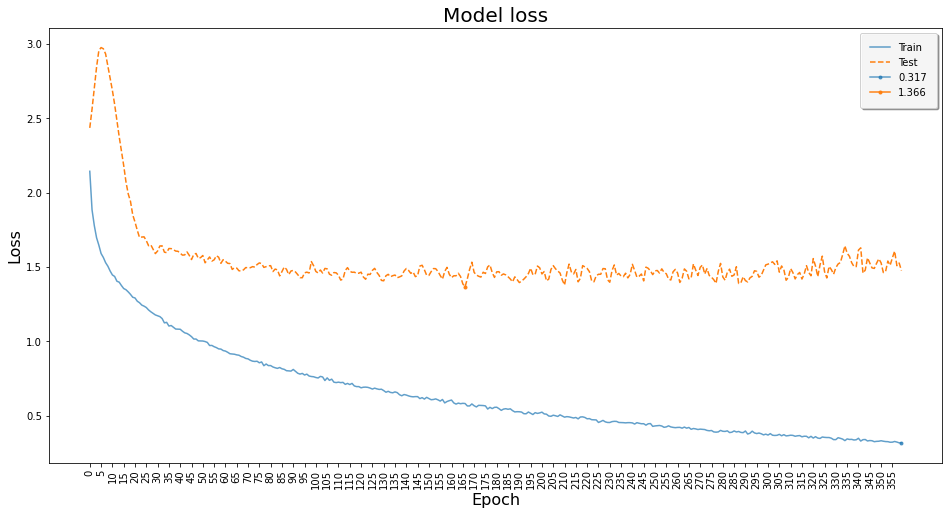

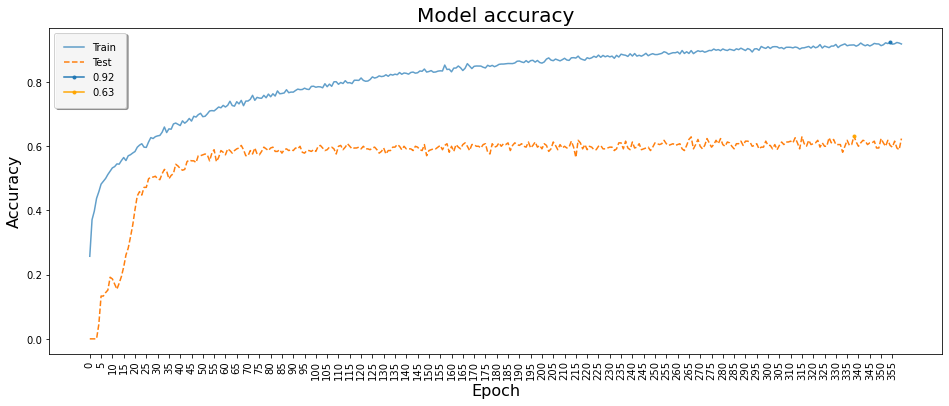

In [21]:
helpers.plot_train_history(history, x_ticks_vertical=True)

###  Model evaluation


#### Register model output

In [22]:
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

#### Confussion matrix

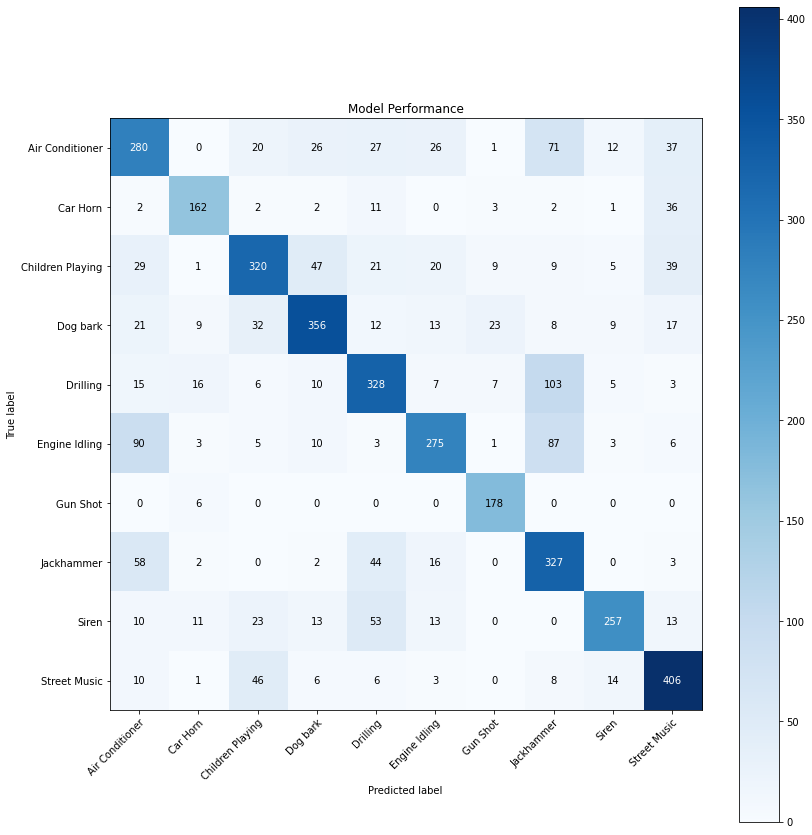

In [23]:
import importlib
importlib.reload(helpers)

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helpers.plot_confusion_matrix(cm,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(12,12))

#### Accuracy table

In [24]:
# Find per-class accuracy from the confusion matrix data
accuracies = helpers.acc_per_class(cm)

pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,96.739130
9,Street Music,81.200000
1,Car Horn,73.303167
7,Jackhammer,72.345133
3,Dog bark,71.200000
4,Drilling,65.600000
8,Siren,65.394402
2,Children Playing,64.000000
5,Engine Idling,56.935818
0,Air Conditioner,56.000000


#### Classification performance: Presicion, Recall and F1 scores

In [25]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.54      0.56      0.55       500
        Car Horn       0.77      0.73      0.75       221
Children Playing       0.70      0.64      0.67       500
        Dog bark       0.75      0.71      0.73       500
        Drilling       0.65      0.66      0.65       500
   Engine Idling       0.74      0.57      0.64       483
        Gun Shot       0.80      0.97      0.88       184
      Jackhammer       0.53      0.72      0.61       452
           Siren       0.84      0.65      0.74       393
    Street Music       0.72      0.81      0.77       500

        accuracy                           0.68      4233
       macro avg       0.71      0.70      0.70      4233
    weighted avg       0.69      0.68      0.68      4233

